In [192]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [193]:
date_parser = lambda x : datetime.strptime(x, '%Y %m %d %H')
df = pd.read_csv("./raw_polution.csv", parse_dates=[['year','month','day', 'hour']], index_col=0, date_parser = date_parser)
df.drop('No', axis=1, inplace=True)
df.tail()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0
2014-12-31 23:00:00,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [194]:
df.columns = ['polution', 'dew', 'temp', 'press', 'wind_dir', 'wind_speed', 'snow', 'rain']
df.index.name='date'
df['polution'].fillna(0,inplace=True)

df.to_csv('./clean_polution.csv')
df.columns, df.head()

(Index(['polution', 'dew', 'temp', 'press', 'wind_dir', 'wind_speed', 'snow',
        'rain'],
       dtype='object'),
                      polution  dew  temp   press wind_dir  wind_speed  snow  \
 date                                                                          
 2010-01-01 00:00:00       0.0  -21 -11.0  1021.0       NW        1.79     0   
 2010-01-01 01:00:00       0.0  -21 -12.0  1020.0       NW        4.92     0   
 2010-01-01 02:00:00       0.0  -21 -11.0  1019.0       NW        6.71     0   
 2010-01-01 03:00:00       0.0  -21 -14.0  1019.0       NW        9.84     0   
 2010-01-01 04:00:00       0.0  -20 -12.0  1018.0       NW       12.97     0   
 
                      rain  
 date                       
 2010-01-01 00:00:00     0  
 2010-01-01 01:00:00     0  
 2010-01-01 02:00:00     0  
 2010-01-01 03:00:00     0  
 2010-01-01 04:00:00     0  )

In [195]:
label_encoder = LabelEncoder()
df['wind_dir'] = label_encoder.fit_transform(df['wind_dir'])
df['wind_dir'].value_counts(), df.head()

(2    15290
 1    14150
 3     9387
 0     4997
 Name: wind_dir, dtype: int64,
                      polution  dew  temp   press  wind_dir  wind_speed  snow  \
 date                                                                           
 2010-01-01 00:00:00       0.0  -21 -11.0  1021.0         1        1.79     0   
 2010-01-01 01:00:00       0.0  -21 -12.0  1020.0         1        4.92     0   
 2010-01-01 02:00:00       0.0  -21 -11.0  1019.0         1        6.71     0   
 2010-01-01 03:00:00       0.0  -21 -14.0  1019.0         1        9.84     0   
 2010-01-01 04:00:00       0.0  -20 -12.0  1018.0         1       12.97     0   
 
                      rain  
 date                       
 2010-01-01 00:00:00     0  
 2010-01-01 01:00:00     0  
 2010-01-01 02:00:00     0  
 2010-01-01 03:00:00     0  
 2010-01-01 04:00:00     0  )

In [196]:
timeseries_data = df.values
timeseries_data.shape, timeseries_data[:3,:]

((43824, 8),
 array([[ 0.000e+00, -2.100e+01, -1.100e+01,  1.021e+03,  1.000e+00,
          1.790e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00, -2.100e+01, -1.200e+01,  1.020e+03,  1.000e+00,
          4.920e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00, -2.100e+01, -1.100e+01,  1.019e+03,  1.000e+00,
          6.710e+00,  0.000e+00,  0.000e+00]]))

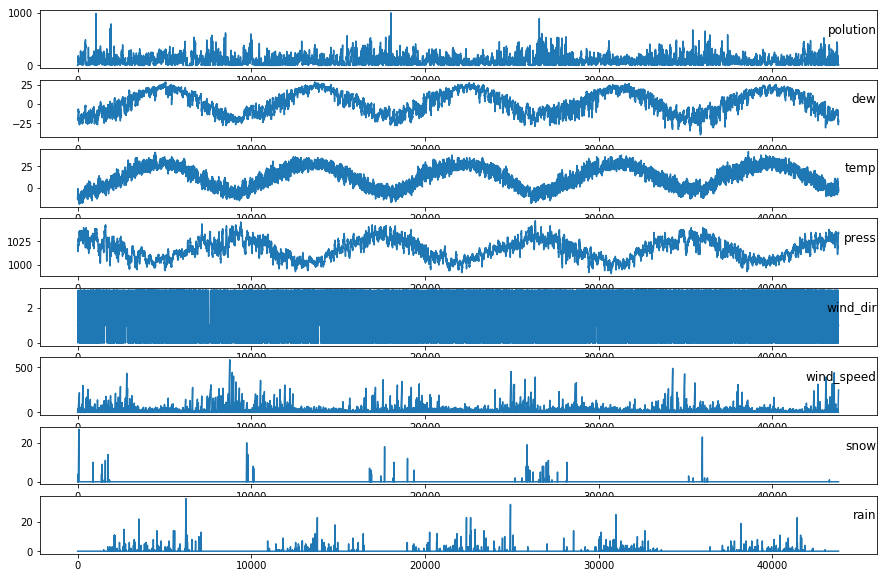

In [197]:
groups = [i for i in range(0,8)]
plt.figure(figsize=(15,10))
i = 1
for g in groups :
    plt.subplot(len(groups), 1, i)
    plt.plot(timeseries_data[:,g])
    plt.title(df.columns[g], y=0.5, loc='right')
    i+=1
plt.show()

In [198]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [199]:
'''
    set input as n_in => 2 jam terakhir
    set output as n_out => 3 jam terakhir
    hasilnya akan menjadi 40 column kenapa karena
    t-2 : 8 column
    t-1 : 8 column
    t : 8 column
    t + 1 : 8 column
    t + 2 : 8 column
'''
n_input_window = 3
n_output_window = 1
dataset_with_window = series_to_supervised(timeseries_data, n_in=n_input_window, n_out=n_output_window)
timeseries_data.shape, dataset_with_window.shape

((43824, 8), (43821, 32))

In [200]:
timeseries_data[0:3], dataset_with_window[:3]

(array([[ 0.000e+00, -2.100e+01, -1.100e+01,  1.021e+03,  1.000e+00,
          1.790e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00, -2.100e+01, -1.200e+01,  1.020e+03,  1.000e+00,
          4.920e+00,  0.000e+00,  0.000e+00],
        [ 0.000e+00, -2.100e+01, -1.100e+01,  1.019e+03,  1.000e+00,
          6.710e+00,  0.000e+00,  0.000e+00]]),
    var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
 3        0.0      -21.0      -11.0     1021.0        1.0       1.79   
 4        0.0      -21.0      -12.0     1020.0        1.0       4.92   
 5        0.0      -21.0      -11.0     1019.0        1.0       6.71   
 
    var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)   ...     var7(t-1)  var8(t-1)  \
 3        0.0        0.0        0.0      -21.0   ...           0.0        0.0   
 4        0.0        0.0        0.0      -21.0   ...           0.0        0.0   
 5        0.0        0.0        0.0      -21.0   ...           0.0        0.0   
 
    var1(t)  var2(t)  var3(t)  var4(t

In [201]:
#example 4 years training and 1 year testing
n_train_hours = 4 * 365 * 24
train = dataset_with_window.values[:n_train_hours, :]
test = dataset_with_window.values[n_train_hours :, :]

train.shape, test.shape

((35040, 32), (8781, 32))

In [202]:
n_features = 8
n_observation = n_input_window * n_features

#yang dijadikan training set hanya t-2, t-1
#yang dijadikan target adalah t+1[-8] atau polusi dari t+1
train_x = train[:, : n_observation]
train_y = train[:, -n_features]

train_x.shape, train_y.shape

((35040, 24), (35040,))

In [203]:
#yang dijadikan training set hanya t-2, t-1 column : 0 - 23
#yang dijadikan target adalah t+1[-8] atau polusi dari t+1
test_x = test[:, : n_observation]
test_y = test[:, -n_features]

test_x.shape, test_y.shape

((8781, 24), (8781,))

In [204]:
train_x = train_x.reshape((train_x.shape[0], n_input_window, n_features))
test_x = test_x.reshape((test_x.shape[0], n_input_window, n_features))

#convert to tuple ()
train_x.shape, test_x.shape

((35040, 3, 8), (8781, 3, 8))

In [205]:
model = Sequential()

model.add(LSTM(50, input_shape = (train_x.shape[1], train_x.shape[2])))
model.add(Dense(units = 1, activation='relu'))

model.compile(loss='mae',
              optimizer='adam')

In [206]:
#if you put validation data it will give the val_loss and history in the result
history = model.fit(train_x, 
                    train_y,
                    batch_size=250,
                    epochs=25,
                    validation_data = (test_x, test_y),
                    verbose=1,
                    shuffle=False)

Train on 35040 samples, validate on 8781 samples
Epoch 1/25
35040/35040 [==============================] - 227s 6ms/step - loss: 92.0517 - val_loss: 93.9849
Epoch 2/25
35040/35040 [==============================] - 2s 46us/step - loss: 90.0108 - val_loss: 91.9695
Epoch 3/25
35040/35040 [==============================] - 2s 46us/step - loss: 88.4758 - val_loss: 90.3890
Epoch 4/25
35040/35040 [==============================] - 2s 47us/step - loss: 87.0334 - val_loss: 88.6947
Epoch 5/25
35040/35040 [==============================] - 2s 47us/step - loss: 85.3772 - val_loss: 87.0436
Epoch 6/25
35040/35040 [==============================] - 2s 46us/step - loss: 83.9450 - val_loss: 85.6416
Epoch 7/25
35040/35040 [==============================] - 2s 55us/step - loss: 82.6831 - val_loss: 84.3890
Epoch 8/25
35040/35040 [==============================] - 2s 47us/step - loss: 81.5476 - val_loss: 83.2487
Epoch 9/25
35040/35040 [==============================] - 2s 46us/step - loss: 80.5047 - val_l

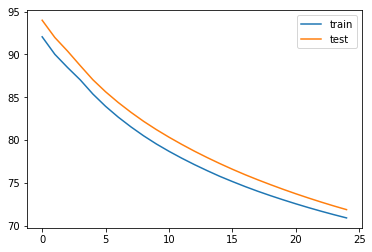

In [207]:
'''
    jika turun grafik masih tajam maka epoch/ iteration masih bisa dapat dilakukan
'''
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [208]:
def r2_score(y_true, y_pred):
    ssres = np.sum(np.square(y_true - y_pred))
    sstot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - ssres / sstot

train_y_predict = model.predict(train_x)
test_y_predict = model.predict(test_x)

r2_score(train_y, train_y_predict), r2_score(test_y, test_y_predict)

(-48604.82721403989, -12440.856230807323)